In [111]:
#@title def hist2otsu
###############################################################################
#####                           hist2otsu                                 #####
#####                        Evan Lahr, 2021                              #####
#####         Compute an Ostu threshold using only histogram data         #####
#####         Similar to MATLAB function 'otsuthresh' (link below)        #####
#####       https://www.mathworks.com/help/images/ref/otsuthresh.html     #####
#####                                                                     #####
#####   INPUT DATA must be a 2-column array of histogram information      #####
#####       COLUMN 1 must be the LOWER BIN EDGES of the histogram         #####
#####       COLUMN 2 must be the NORMALIZED COUNTS of the histogram       #####
##### OUTPUT is the otsu threshold value (thresh min intraclass variance) #####
###############################################################################


def hist2otsu(hist):
    bins    = np.array([item[0] for item in hist])
    counts  = np.array([item[1] for item in hist])
    binstep = bins[1] - bins[0]
    midpts  = np.array([x+(binstep/2) for x in bins])

    total_weight   = sum(counts)
    least_variance = -1
    least_variance_threshold = -1
    
    #create an array of all possible threshold values to loop through
    thresholds = np.arange(np.min(bins), np.max(bins), binstep)

    #loop through thresholds to find the minimum intraclass class variance
    for i in thresholds:
        bg_midpts = midpts[bins <= i]
        bg_counts = counts[bins <= i]
        if sum(bg_counts) == 0:
          continue
        weight_bg = sum(bg_counts) / total_weight
        mean_bg = np.average(bg_midpts, weights=bg_counts)
        variance_bg = np.average((bg_midpts - mean_bg)**2, weights=bg_counts)

        fg_midpts = midpts[bins > i]
        fg_counts = counts[bins > i]
        if sum(fg_counts) == 0:
           continue
        weight_fg = sum(fg_counts) / total_weight
        mean_fg = np.average(fg_midpts, weights=fg_counts)
        variance_fg = np.average((fg_midpts - mean_fg)**2, weights=fg_counts)

        within_class_variance = weight_fg*variance_fg + weight_bg*variance_bg
        if least_variance == -1 or least_variance > within_class_variance:
            least_variance = within_class_variance
            least_variance_threshold = i
            #print("var:", within_class_variance, "  thresh:", i)
    return least_variance_threshold

In [112]:
#@title implement the otsu threshold over an image
import numpy as np
import pandas as pd
from skimage import data
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

#get an image for thresholding
image = data.camera()
#Create an image histogram for hist2otsu, 256 bins
hist256=np.histogram(image, bins=256, normed=1)
hist256=pd.DataFrame(data=hist256).transpose().iloc[:, ::-1]
hist256.drop(hist256.tail(1).index,inplace=True)
hist256=[list(x) for x in hist256.values]
#Create an image histogram for hist2otsu, 64 bins
hist16=np.histogram(image, bins=16, normed=1)
hist16=pd.DataFrame(data=hist16).transpose().iloc[:, ::-1]
hist16.drop(hist16.tail(1).index,inplace=True)
hist16=[list(x) for x in hist16.values]

#compute skimage otsu threshold
thresh_skimage = threshold_otsu(image)
#binarize using skimage threshold
binary_skimage = image > thresh

#compute hist2otsu otsu threshold, nbins=256
thresh_histogram_256 = hist2otsu(hist256)
binary_histogram_256 = image > thresh
#compute hist2otsu otsu threshold, nbins=64
thresh_histogram_16 = hist2otsu(hist16)
binary_histogram_16 = image > thresh

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  from ipykernel import kernelapp as app


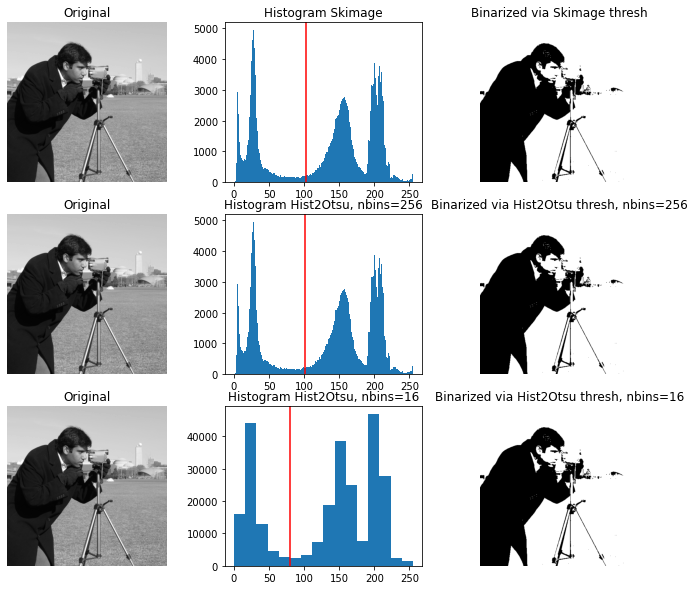

In [115]:
#@title Plot images, thresholded using different methods
fig, axes = plt.subplots(ncols=3,nrows=3,figsize=(12, 10))
ax = axes.ravel()
ax[0] = plt.subplot(331)
ax[1] = plt.subplot(332)
ax[2] = plt.subplot(333, sharex=ax[0], sharey=ax[0])
ax[3] = plt.subplot(334)
ax[4] = plt.subplot(335)
ax[5] = plt.subplot(336, sharex=ax[0], sharey=ax[0])
ax[6] = plt.subplot(337)
ax[7] = plt.subplot(338)
ax[8] = plt.subplot(339, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram Skimage')
ax[1].axvline(thresh_skimage, color='r')

ax[2].imshow(binary_skimage, cmap=plt.cm.gray)
ax[2].set_title('Binarized via Skimage thresh')
ax[2].axis('off')

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].set_title('Original')
ax[3].axis('off')

ax[4].hist(image.ravel(), bins=256)
ax[4].set_title('Histogram Hist2Otsu, nbins=256')
ax[4].axvline(thresh_histogram_256, color='r')

ax[5].imshow(binary_histogram_256, cmap=plt.cm.gray)
ax[5].set_title('Binarized via Hist2Otsu thresh, nbins=256')
ax[5].axis('off')

ax[6].imshow(image, cmap=plt.cm.gray)
ax[6].set_title('Original')
ax[6].axis('off')

ax[7].hist(image.ravel(), bins=16)
ax[7].set_title('Histogram Hist2Otsu, nbins=16')
ax[7].axvline(thresh_histogram_16, color='r')

ax[8].imshow(binary_histogram_16, cmap=plt.cm.gray)
ax[8].set_title('Binarized via Hist2Otsu thresh, nbins=16')
ax[8].axis('off')

plt.show()

NOTICE: the calculated threshold value inherently changes based on bin resolution.